# Classifying MNIST using PCA + deep learning 

In [1]:
%load_ext nb_black

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

<IPython.core.display.Javascript object>

This tutorial was done using the [Toward's data science article.](https://towardsdatascience.com/classifying-mnist-digits-using-pca-deep-learning-852aeaff48a5)

The data was obtained from [Kaggle.](https://www.kaggle.com/c/digit-recognizer/overview)

The MNIST Dataset (Modified National Institute of Standards and Technology database) is one of the more popular datasets among deep learning enthusiasts. This dataset contains 42,000 labeled grayscale images (28 x 28 pixel) of handwritten digits from 0–9 in their training set and 28,000 unlabeled test images.

The aim is to use PCA in building a CNN model to recognize handwritten digits from the MNIST Dataset to achieve high accuracy.

### Importing libraries 

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (
    Input,
    Dense,
    InputLayer,
    Activation,
    ZeroPadding2D,
    BatchNormalization,
    Flatten,
    Conv2D,
)
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from scipy.linalg import eigh

<IPython.core.display.Javascript object>

### Loading dataset 

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [4]:
train.shape

(42000, 785)

<IPython.core.display.Javascript object>

As mentioned above, the training data consists of 42000 rows and 785 columns (28*28 pixels + 1 label column). Below are sample images from the dataset:

![](https://miro.medium.com/max/875/1*hrgRNKFGIBcQ5FbH6z3PUA.png)

### Pre-processing the data 

In [5]:
X_train = train.drop(["label"], axis=1)
y_train = train["label"]

<IPython.core.display.Javascript object>

In [6]:
X_test = test

<IPython.core.display.Javascript object>

In [7]:
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (28000, 784))

<IPython.core.display.Javascript object>

Labels are not given for the test set. Hence no y_test.

In [8]:
X_train = X_train / 255
X_test = X_test / 255

<IPython.core.display.Javascript object>

### Standardization and PCA implementation 

In [9]:
standard_scalar = StandardScaler()
standard_data = standard_scalar.fit_transform(X_train)
standard_data.shape

(42000, 784)

<IPython.core.display.Javascript object>

In [10]:
cov_matrix = np.matmul(standard_data.T, standard_data)
cov_matrix.shape

(784, 784)

<IPython.core.display.Javascript object>

Covariance can be thought of as the direction of linear relationship between the variables. The covariance matrix is the first step in dimensionality reduction because it gives an idea of the number of features that strongly relate so that those features can be discarded.

In [11]:
lambdas, vectors = eigh(
    cov_matrix, eigvals=(782, 783)
)  # calculating eigen values and vectors
vectors.shape

(784, 2)

<IPython.core.display.Javascript object>

In [12]:
vectors = vectors.T
vectors.shape

(2, 784)

<IPython.core.display.Javascript object>

Eigenvectors and eigenvalues ​​of a covariance matrix (or correlation) describe the source of the PCA. Eigenvectors (main components) determine the direction of the new attribute space, and eigenvalues ​​determine its magnitude.

In [13]:
new_coords = np.matmul(vectors, standard_data.T)
print(new_coords.shape)

(2, 42000)


<IPython.core.display.Javascript object>

In [14]:
new_coords = np.vstack((new_coords, y_train)).T  # stacking array in vertical sequence

<IPython.core.display.Javascript object>

In [15]:
df_new = pd.DataFrame(new_coords, columns=["f1", "f2", "labels"])
df_new.head()

,f1,f2,labels
0,-5.226445,-5.140478,1.0
1,6.032996,19.292332,0.0
2,-1.705813,-7.644503,1.0
3,5.836139,-0.474207,4.0
4,6.024818,26.559574,0.0


<IPython.core.display.Javascript object>

Unit vectors are vectors with a magnitude of 1, and we are trying to find the unit vector that maximizes the variance.

In [16]:
pca = PCA()
pca.n_components = 784
pca_data = pca.fit_transform(standard_data)
percent_variance_retained = pca.explained_variance_ / np.sum(pca.explained_variance_)
cum_variance_retained = np.cumsum(percent_variance_retained)

<IPython.core.display.Javascript object>

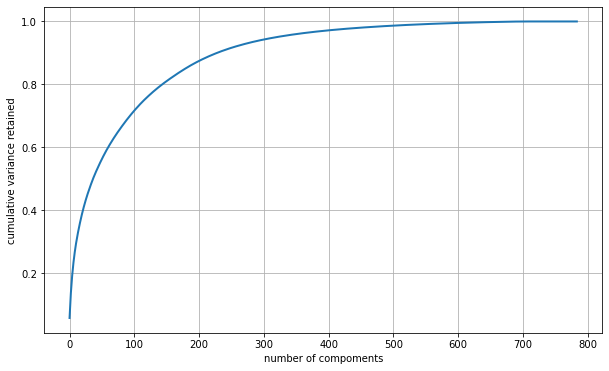

<IPython.core.display.Javascript object>

In [17]:
plt.figure(1, figsize=(10, 6))
plt.clf()
plt.plot(cum_variance_retained, linewidth=2)
plt.axis("tight")
plt.grid()
plt.xlabel("number of compoments")
plt.ylabel("cumulative variance retained")
plt.savefig("pca_cumulative_variance.png")
plt.show()

Visualization of the cumulative variance retained across the number of components (784).

### Creating CNN model 

Certain preprocessing steps before building the model includes converting the training set into an array, reshaping the input data to get it in the shape which the model expect to receive later, and encoding the image labels.

In [18]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
print(X_train.shape, y_train.shape)

(42000, 28, 28, 1) (42000,)


<IPython.core.display.Javascript object>

In [19]:
n_classes = y_train.max() - y_train.min() + 1
y_train = to_categorical(y_train, num_classes=n_classes)
print("Shape of y_train after encoding:", y_train.shape)

Shape of y_train after encoding: (42000, 10)


<IPython.core.display.Javascript object>

Building a 2D CNN model with 3 layers and 1 fully connected layer.

In [20]:
input_shape = (28, 28, 1)
X_input = Input(input_shape)

<IPython.core.display.Javascript object>

In [21]:
# layer 1
x = Conv2D(64, (3, 3), strides=(1, 1), name="layer_conv1", padding="same")(X_input)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2), name="maxPool1")(x)

# layer 2
x = Conv2D(32, (3, 3), strides=(1, 1), name="layer_conv2", padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2), name="maxPool2")(x)

# layer 3
x = Conv2D(32, (3, 3), strides=(1, 1), name="conv3", padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2), name="maxPool3")(x)

# fully connected layer
x = Flatten()(x)
x = Dense(64, activation="relu", name="fc0")(x)
x = Dropout(0.25)(x)
x = Dense(32, activation="relu", name="fc1")(x)
x = Dropout(0.25)(x)
x = Dense(10, activation="softmax", name="fc2")(x)

<IPython.core.display.Javascript object>

In [22]:
conv_model = Model(inputs=X_input, outputs=x, name="Predict")
conv_model.summary()

Model: "Predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 64)        0         
_________________________________________________________________
maxPool1 (MaxPooling2D)      (None, 14, 14, 64)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128 

<IPython.core.display.Javascript object>

In [23]:
conv_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

<IPython.core.display.Javascript object>

In [24]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_accuracy", patience=3)

<IPython.core.display.Javascript object>

In [25]:
model_history = conv_model.fit(
    X_train,
    y_train,
    shuffle=True,
    epochs=40,
    batch_size=100,
    validation_split=0.2,
    callbacks=[early_stopping],
)

Epoch 1/40
336/336 [==============================] - 48s 140ms/step - loss: 1.0114 - accuracy: 0.6688 - val_loss: 2.2953 - val_accuracy: 0.2500
Epoch 2/40
336/336 [==============================] - 44s 131ms/step - loss: 0.1554 - accuracy: 0.9568 - val_loss: 0.1461 - val_accuracy: 0.9557
Epoch 3/40
336/336 [==============================] - 44s 131ms/step - loss: 0.1072 - accuracy: 0.9708 - val_loss: 0.0681 - val_accuracy: 0.9811
Epoch 4/40
336/336 [==============================] - 44s 131ms/step - loss: 0.0835 - accuracy: 0.9762 - val_loss: 0.0448 - val_accuracy: 0.9865
Epoch 5/40
336/336 [==============================] - 44s 131ms/step - loss: 0.0666 - accuracy: 0.9823 - val_loss: 0.0436 - val_accuracy: 0.9870
Epoch 6/40
336/336 [==============================] - 45s 135ms/step - loss: 0.0569 - accuracy: 0.9841 - val_loss: 0.0534 - val_accuracy: 0.9876
Epoch 7/40
336/336 [==============================] - 47s 140ms/step - loss: 0.0526 - accuracy: 0.9858 - val_loss: 0.0462 - val_ac

<IPython.core.display.Javascript object>

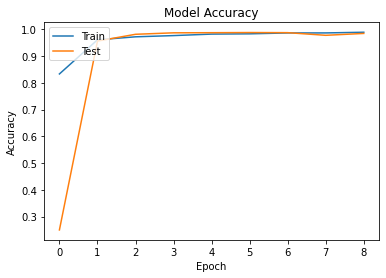

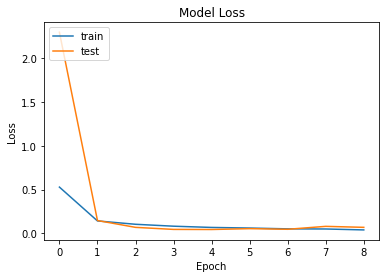

<IPython.core.display.Javascript object>

In [26]:
# Training vs Validation set accuracies over epochs
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.savefig("Model_Accuracy.png")
plt.show()

# Training vs validation set losses over epochs
plt.plot(model_history.history["loss"])
plt.plot(model_history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "test"], loc="upper left")
plt.savefig("Model_loss.png")
plt.show()

In [27]:
print("Loss of the model is - ", conv_model.evaluate(X_train, y_train)[0])
print(
    "Accuracy of the model is - ", conv_model.evaluate(X_train, y_train)[1] * 100, "%"
)

1313/1313 [==============================] - 12s 9ms/step - loss: 0.0407 - accuracy: 0.9897
Loss of the model is -  0.04071016237139702
1313/1313 [==============================] - 11s 9ms/step - loss: 0.0407 - accuracy: 0.9897
Accuracy of the model is -  98.971426486969 %


<IPython.core.display.Javascript object>

We are able to achieve an accuracy of more than 98% after 9 epochs.